In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Found 188 CSV files


Loading datasets:  11%|█         | 21/188 [00:00<00:02, 67.87it/s]


detected high steering, skip this set: data_synced/b0c9d2329ad1606b|2018-07-29--11-17-20_4.csv

Dataset sizes:
Total samples: 23738
Train: 16616 (70.0%)
Validation: 3561 (15.0%)
Test: 3561 (15.0%)

Visualizing sample datapoints from training set...


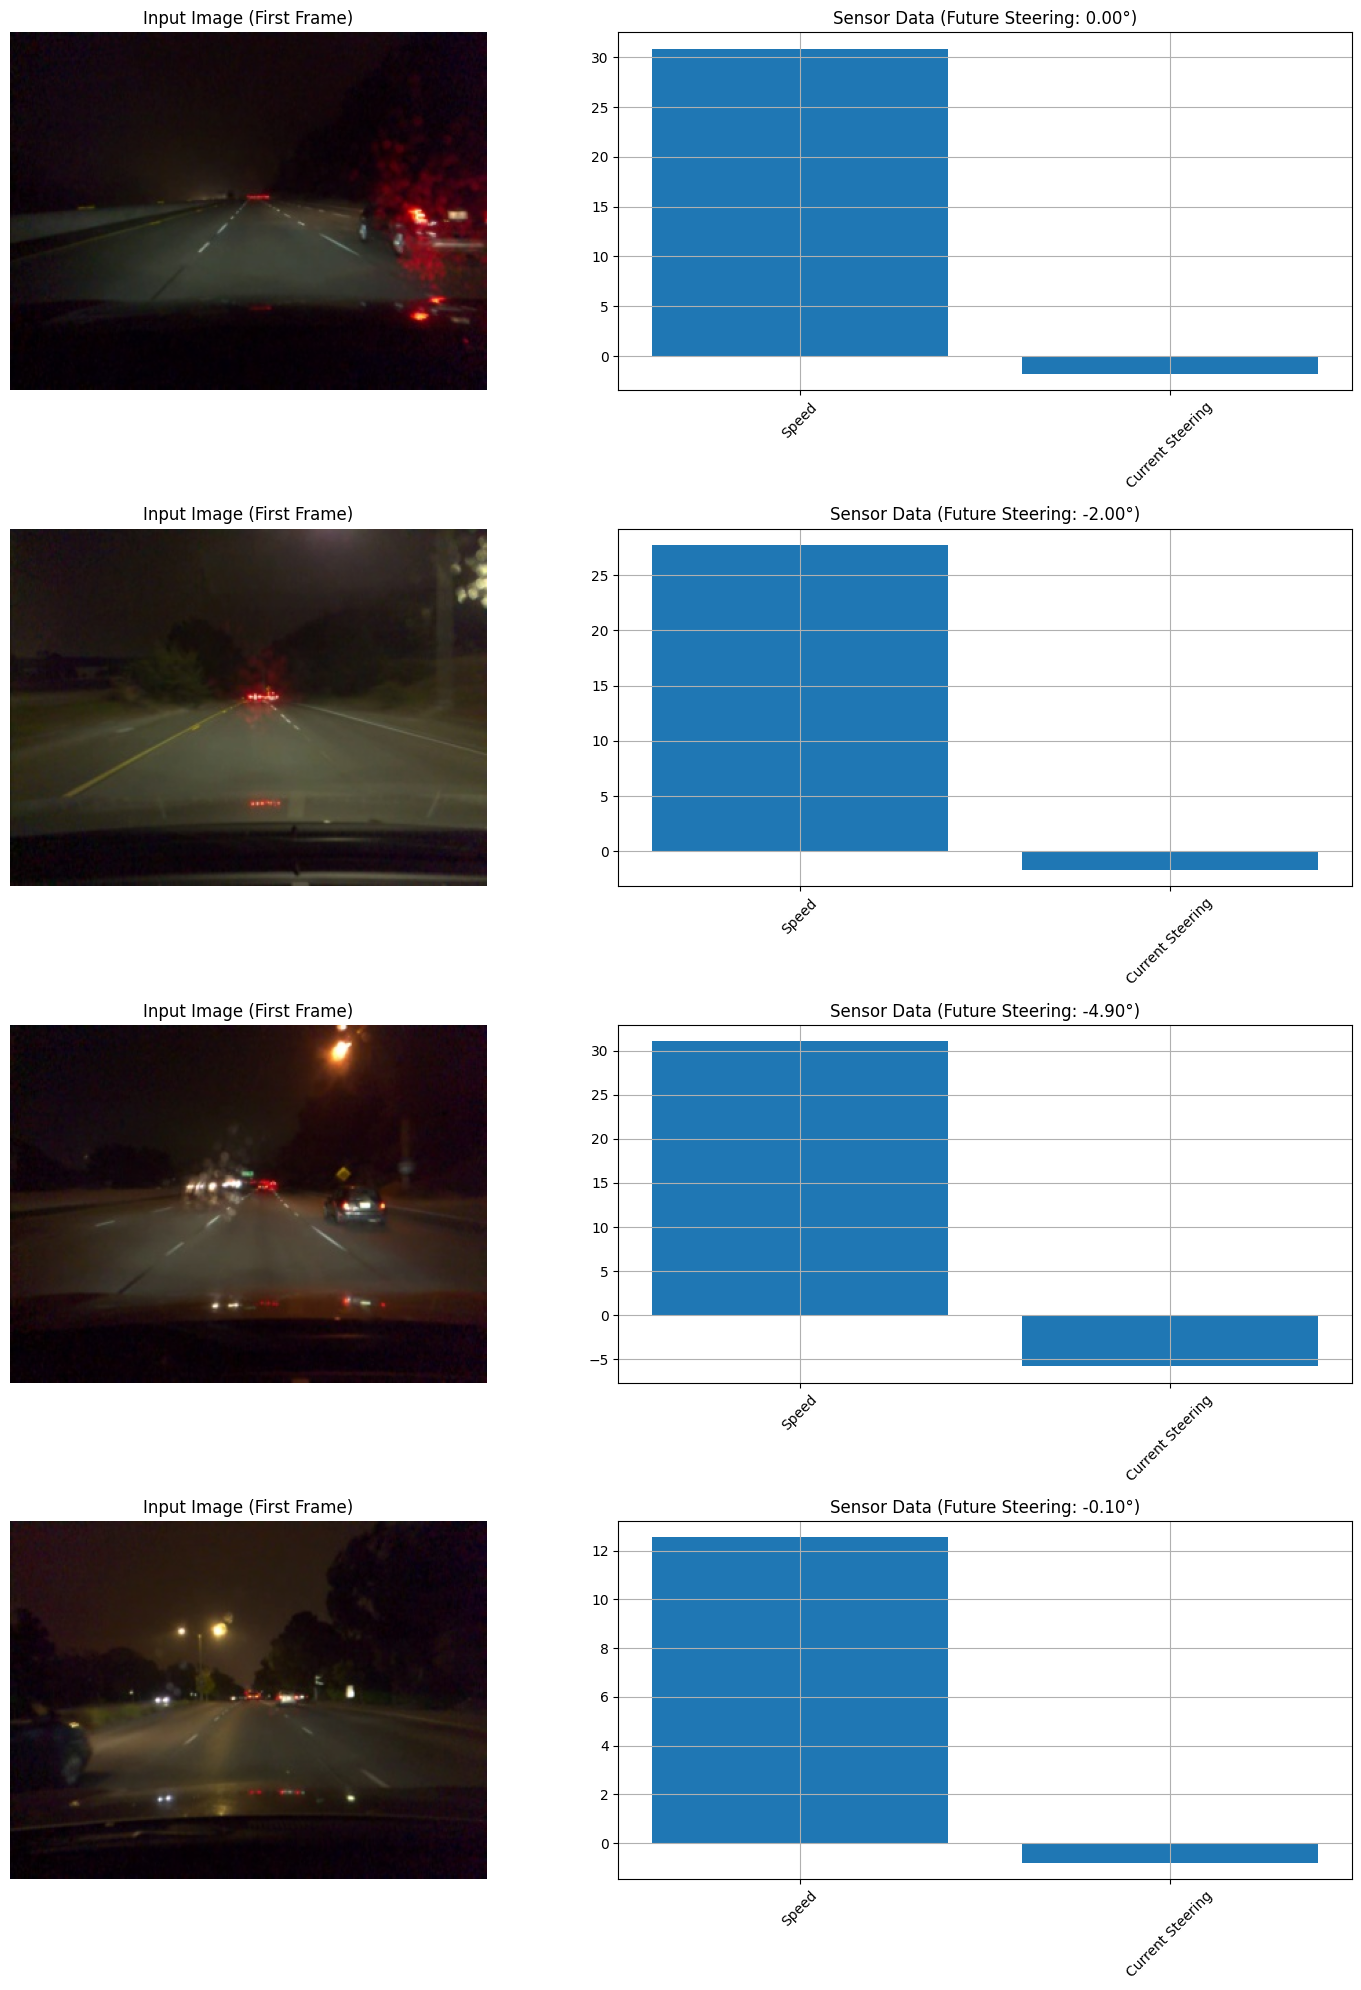

In [2]:
import glob
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define base directory paths
DATA_DIR = 'data_synced'  # Directory containing processed CSV files and frame folders

class SequentialDrivingDataset(Dataset):
    def __init__(self, csv_file, sequence_length=10, transform=None):
        self.sequence_length = sequence_length
        self.data = pd.read_csv(csv_file)
        
        # Get frames directory path from CSV filename
        filename = os.path.basename(csv_file)
        self.frames_dir = os.path.join(DATA_DIR, f"{filename[:-4]}_frames")
        
        # Verify frames directory exists
        if not os.path.exists(self.frames_dir):
            raise FileNotFoundError(f"Frames directory not found: {self.frames_dir}")
        
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])
        
        # Create sequences
        self.sequences = []
        total_frames = len(self.data)
        for i in range(total_frames - sequence_length + 1):
            self.sequences.append(i)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence_start = self.sequences[idx]
        
        # Initialize sequence containers
        image_sequence = []
        sensor_sequence = []
        target_sequence = []
        
        # Build sequence
        for i in range(self.sequence_length):
            frame_idx = sequence_start + i
            row = self.data.iloc[frame_idx]
            
            # Load image
            frame_path = os.path.join(self.frames_dir, f"{int(row['frame_idx'])}.jpg")
            frame = Image.open(frame_path).convert('RGB')
            if self.transform:
                frame = self.transform(frame)
            image_sequence.append(frame)
            
            # Get sensor data
            speed_value = float(row['speed'].strip('[]') if isinstance(row['speed'], str) else row['speed'])
            sensor_data = torch.tensor([
                speed_value,
                #row['gyro_x'], row['gyro_y'], row['gyro_z'],
                row['current_steering'],
            ], dtype=torch.float32)
            sensor_sequence.append(sensor_data)
            
            # Get target (future steering angle)
            target = torch.tensor(row['future_steering'], dtype=torch.float32)
            target_sequence.append(target)
        
        # Stack sequences
        image_sequence = torch.stack(image_sequence)  # [T, C, H, W]
        sensor_sequence = torch.stack(sensor_sequence)  # [T, 7]
        
        
        return image_sequence, sensor_sequence, target_sequence[-1]

def visualize_sample_datapoints(dataset, num_samples=4):
    """
    Visualize a few sample datapoints from the dataset to verify format
    Shows the first frame from each sequence
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Get a random sample
        idx = np.random.randint(len(dataset))
        image_sequence, sensor_sequence, target = dataset[idx]
        
        # Take first frame and sensor data from the sequence
        image = image_sequence[0]  # First frame
        sensor_data = sensor_sequence[0]  # First sensor reading
        
        # Convert image tensor back to displayable format
        img = image.numpy().transpose(1, 2, 0)
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Plot image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input Image (First Frame)')
        axes[i, 0].axis('off')
        
        # Create sensor data visualization
        sensor_labels = [
            'Speed', 
            #'Gyro X', 'Gyro Y', 'Gyro Z',
            'Current Steering',
        ]
        
        # Plot sensor data as a bar chart
        axes[i, 1].bar(sensor_labels, sensor_data.numpy())
        axes[i, 1].set_title(f'Sensor Data (Future Steering: {target:.2f}°)')
        axes[i, 1].tick_params(axis='x', rotation=45)
        axes[i, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Get list of all CSV files in data_synced
csv_files = [f for f in glob.glob('data_synced/*.csv') if 'combined_dataset.csv' not in f]
print(f"Found {len(csv_files)} CSV files")

# Create datasets for each segment
datasets = []
counter = 0
for csv_file in tqdm(csv_files, desc="Loading datasets"):
    try:
        if (counter > 19):
            break
        data_for_large_steer_angle_check = pd.read_csv(csv_file)
        if (((data_for_large_steer_angle_check['future_steering'] > 45).any()) | ((data_for_large_steer_angle_check['future_steering'] < -45).any())):
            print("detected high steering, skip this set:", csv_file)
            continue
        dataset = SequentialDrivingDataset(csv_file)
        datasets.append(dataset)
        counter = counter + 1
    except Exception as e:
        print(f"Error loading {csv_file}: {str(e)}")
        continue

if not datasets:
    raise RuntimeError("No datasets were successfully loaded!")

# Combine all datasets
full_dataset = ConcatDataset(datasets)
total_size = len(full_dataset)

# Split dataset into train, validation, and test sets (70%, 15%, 15%)
total_len = len(full_dataset)
train_end = int(0.7 * total_len)
val_end = int(0.85 * total_len)

train_dataset = Subset(full_dataset, list(range(0, train_end)))
val_dataset = Subset(full_dataset, list(range(train_end, val_end)))
test_dataset = Subset(full_dataset, list(range(val_end, total_len)))

print(f"\nDataset sizes:")
print(f"Total samples: {total_size}")
print(f"Train: {len(train_dataset)} ({len(train_dataset)/total_size*100:.1f}%)")
print(f"Validation: {len(val_dataset)} ({len(val_dataset)/total_size*100:.1f}%)")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/total_size*100:.1f}%)")

# Create data loaders with no workers for simplicity
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Visualize some samples to verify data format
print("\nVisualizing sample datapoints from training set...")
visualize_sample_datapoints(train_dataset)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class SteeringRNN(nn.Module):
    """
    RNN model for predicting steering angles with proper temporal processing.
    """
    def __init__(self, sequence_length=10, hidden_size=64):
        super(SteeringRNN, self).__init__()
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.sensor_input_size = 2

        # CNN layers for visual feature extraction (same as before)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(24),

            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(36),

            nn.Dropout(0.15),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(48),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Dropout(0.15),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Dropout(0.15),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        # Calculate CNN output size
        with torch.no_grad():
            dummy_img = torch.zeros(1, 3, 260, 346) 
            dummy_features = self.conv_layers(dummy_img)
            self.cnn_output_size = dummy_features.view(-1).shape[0]
            print(f"CNN output size per frame: {self.cnn_output_size}")


        # Feature fusion layer to combine CNN and sensor features
        self.cnn_last_layer = nn.Sequential(
            nn.Linear(self.cnn_output_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            #nn.Dropout(0.2)
        )

        # RNN layer - takes fused features as input
        self.rnn = nn.LSTM(
            input_size=128 + 2,  # Size of fused features
            hidden_size=hidden_size,
            batch_first=True,
            #dropout=0.2
        )

        # Final prediction layer
        self.final = nn.Sequential(
            nn.Linear(hidden_size, 1),
        )

    def forward(self, image_sequence, sensor_sequence):
        """
        Forward pass with parallel CNN processing.
        Args:
            image_sequence: [batch_size, sequence_length, channels, height, width]
            sensor_sequence: [batch_size, sequence_length, sensor_features]
        Returns:
            predictions: [batch_size, sequence_length, 1]
        """
        batch_size = image_sequence.size(0)
        sequence_length = image_sequence.size(1)
        device = image_sequence.device

        # Initialize LSTM hidden state
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        hidden = (h0, c0)

        # Process all frames through CNN at once
        # Reshape from [B, T, C, H, W] to [B*T, C, H, W]
        images_reshaped = image_sequence.view(-1, 3, 260, 346)
        visual_features = self.conv_layers(images_reshaped)
        visual_features = visual_features.view(batch_size, sequence_length, -1)
        
        visual_features = visual_features.view(batch_size * sequence_length, -1)
        visual_features = self.cnn_last_layer(visual_features)
        visual_features = visual_features.view(batch_size, sequence_length, -1)

        sensor_sequence = sensor_sequence.view(batch_size, sequence_length, -1)
        
        combined = torch.cat([visual_features, sensor_sequence], dim=2)

        # Process through RNN
        rnn_out, _ = self.rnn(combined, hidden)

        # Make prediction for last timestep only
        last_rnn_output = rnn_out[:, -1, :]
        predictions = self.final(last_rnn_output)  # Shape: [batch_size, 1]

        return predictions

    def init_hidden(self, batch_size, device):
        """Initialize hidden state"""
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        return (h0, c0)

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    """
    Train the model with early stopping.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"\nGPU Information:")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name()}")
        print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    model.to(device)
    print(f"Training on {device}")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for image_sequence, sensor_sequence, target in pbar:
                # Move data to device
                image_sequence = image_sequence.to(device)  # [B, T, C, H, W]
                sensor_sequence = sensor_sequence.to(device)  # [B, T, 11]
                # Reshape target to match model output
                target = target.to(device).unsqueeze(-1)  # [B, 1]
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(image_sequence, sensor_sequence)  # [B, 1]
                
                # Compute loss
                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * image_sequence.size(0)
                pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for image_sequence, sensor_sequence, target in val_loader:
                image_sequence = image_sequence.to(device)
                sensor_sequence = sensor_sequence.to(device)
                target = target.to(device).unsqueeze(-1)  # Add dimension here too
                
                outputs = model(image_sequence, sensor_sequence)
                loss = criterion(outputs, target)
                running_loss += loss.item() * image_sequence.size(0)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)
    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    return model, train_losses, val_losses

In [12]:
def test_model(model, test_loader, sample_rate = 10):
    """
    Test the model with steering-specific metrics for future steering angle prediction.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for image_sequence, sensor_sequence, target in test_loader:
            image_sequence = image_sequence.to(device)
            sensor_sequence = sensor_sequence.to(device)
            target = target.to(device)
            
            outputs = model(image_sequence, sensor_sequence)
            
            # Flatten sequences for metrics
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    sampled_preds = all_preds[::sample_rate]
    sampled_targets = all_targets[::sample_rate]
    sampled_preds = sampled_preds[0:400]
    sampled_targets = sampled_targets[0:400]

    # Calculate metrics
    mse = np.mean((all_preds - all_targets) ** 2)
    mae = np.mean(np.abs(all_preds - all_targets))
    within_1_deg = np.mean(np.abs(all_preds - all_targets) < 1.0) * 100
    within_3_deg = np.mean(np.abs(all_preds - all_targets) < 3.0) * 100
    within_5_deg = np.mean(np.abs(all_preds - all_targets) < 5.0) * 100

    print("\nTest Results (Predicting Steering Angle at t+200ms):")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Prediction vs Ground Truth
    plt.subplot(1, 2, 1)
    plt.plot(sampled_preds, label='Future Ground Truth', alpha=0.7)
    plt.plot(sampled_targets, label='Predicted Future', alpha=0.7)
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title(f'Predicted vs Actual Future Steering Angles (Sampled every {sample_rate} data points)')
    plt.legend()

    # Correlation plot
    plt.subplot(1, 2, 2)
    plt.scatter(all_targets, all_preds, alpha=0.1)
    plt.plot([-45, 45], [-45, 45], 'r--')
    plt.xlabel('Actual Future Steering Angle (degrees)')
    plt.ylabel('Predicted Future Steering Angle (degrees)')
    plt.title('Prediction Correlation (t+200ms)')

    plt.tight_layout()
    plt.show()

CNN output size per frame: 1792

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4070 Ti SUPER
Device memory: 17.17 GB
Training on cuda:0


Epoch 1/10: 100%|██████████| 260/260 [04:31<00:00,  1.04s/it, loss=5.73] 


Epoch 1: Train Loss: 6.2350, Val Loss: 6.4308


Epoch 2/10: 100%|██████████| 260/260 [04:30<00:00,  1.04s/it, loss=0.606]


Epoch 2: Train Loss: 1.6768, Val Loss: 4.1579


Epoch 3/10: 100%|██████████| 260/260 [04:31<00:00,  1.04s/it, loss=0.358]


Epoch 3: Train Loss: 0.8452, Val Loss: 3.1069


Epoch 4/10: 100%|██████████| 260/260 [04:27<00:00,  1.03s/it, loss=0.872]


Epoch 4: Train Loss: 0.5731, Val Loss: 2.7744


Epoch 5/10: 100%|██████████| 260/260 [04:33<00:00,  1.05s/it, loss=0.316]


Epoch 5: Train Loss: 0.4426, Val Loss: 2.6699


Epoch 6/10: 100%|██████████| 260/260 [04:31<00:00,  1.04s/it, loss=0.341]


Epoch 6: Train Loss: 0.3683, Val Loss: 3.1625


Epoch 7/10: 100%|██████████| 260/260 [04:25<00:00,  1.02s/it, loss=0.214]


Epoch 7: Train Loss: 0.3131, Val Loss: 2.9162


Epoch 8/10: 100%|██████████| 260/260 [04:28<00:00,  1.03s/it, loss=0.113]


Epoch 8: Train Loss: 0.2925, Val Loss: 3.2439


Epoch 9/10: 100%|██████████| 260/260 [04:27<00:00,  1.03s/it, loss=0.185] 


Epoch 9: Train Loss: 0.2323, Val Loss: 3.6116


Epoch 10/10: 100%|██████████| 260/260 [04:26<00:00,  1.03s/it, loss=0.215] 


Epoch 10: Train Loss: 0.2102, Val Loss: 3.4425


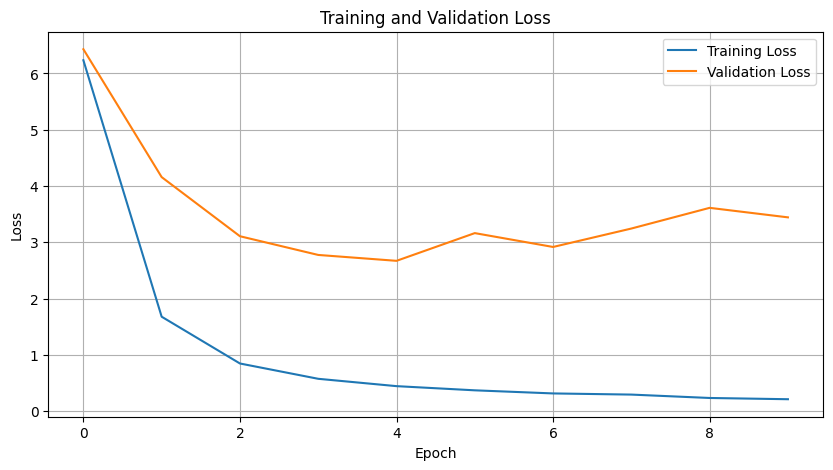


Model saved to 'v4_RNN_reduced2.pth'

Testing the model...

Test Results (Predicting Steering Angle at t+200ms):
MSE: 1.1398 degrees²
MAE: 0.6828 degrees
Predictions within 1°: 79.9%
Predictions within 3°: 97.6%
Predictions within 5°: 99.6%


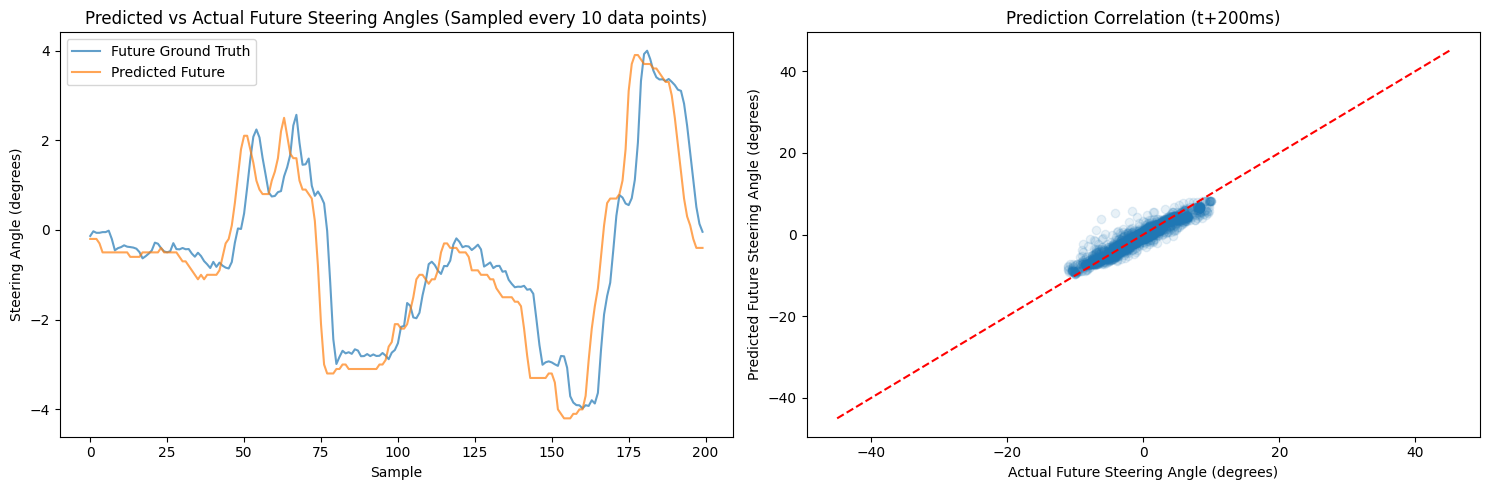

In [ ]:
# Initialize model and training components
model = SteeringRNN(sequence_length=10, hidden_size=64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the model
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    patience=8
)

# Save the trained model
torch.save(model.state_dict(), 'v4_RNN.pth')
print("\nModel saved to 'v4_RNN.pth'")

# Test the model
print("\nTesting the model...")
test_model(model, test_loader)


In [ ]:

def visualize_sequence_predictions(model, test_loader):
    model.eval()
    device = next(model.parameters()).device

    # Get a single batch
    image_sequence, sensor_sequence, target = next(iter(test_loader))
    image_sequence = image_sequence.to(device)
    sensor_sequence = sensor_sequence.to(device)

    with torch.no_grad():
        predictions = model(image_sequence, sensor_sequence)

    # Convert to numpy for visualization
    predictions = predictions.cpu().numpy()
    target = target.numpy()

    # Plot a few examples
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    for i in range(min(6, len(predictions))):
        ax = axes[i//2, i%2]

        # Get the last frame of the sequence
        img = image_sequence[i, -1].cpu().numpy().transpose(1, 2, 0)

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f'Predicted (t+200ms): {predictions[i, 0]:.1f}°\nActual (t+200ms): {target[i]:.1f}°')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing some predictions...")
visualize_sequence_predictions(model, test_loader)


Test Results (Predicting Steering Angle at t+200ms):
MSE: 1.1398 degrees²
MAE: 0.6828 degrees
Predictions within 1°: 79.9%
Predictions within 3°: 97.6%
Predictions within 5°: 99.6%


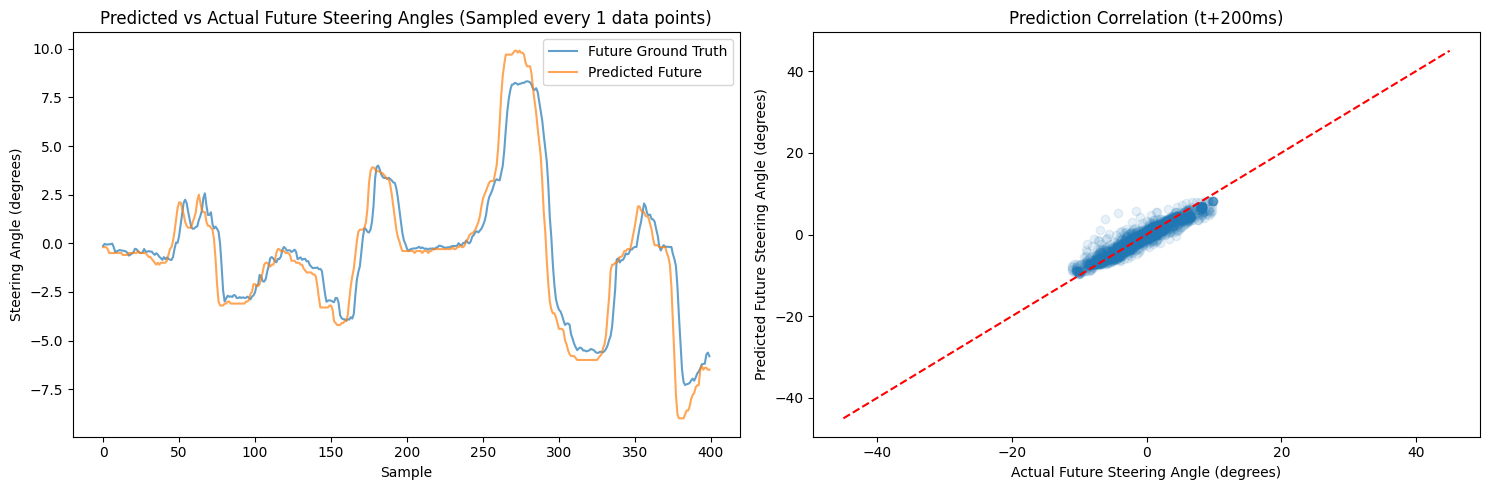

In [ ]:
#model = SteeringRNN()
#model.load_state_dict(torch.load('v4_RNN.pth'))

test_model(model, test_loader, sample_rate = 1)